# Single Envelope Model

The goal is to start exploring parametric downconversion.

## The code

We begin by importing the modules needed, including my own. I also run some formatting scripts. You can safely ignore all this.

In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, fftfreq
import matplotlib.pyplot as plt
import time
from scipy import fftpack as sp
from scipy import signal
import copy
from matplotlib import cm
import colorcet as cc
from matplotlib.colors import Normalize

#This are my libraries
import nlo 
import materials
import waveguides
from util import sech

In [2]:
#Formatting stuff
from IPython.core.display import HTML
def css_styling():
    styles = open("custom.css", "r").read()
    return HTML(styles)
css_styling()

In [3]:
plt.rcParams.update({'font.size': 18})

## Units
We'll work in SI base units for the most part. Here we load some constants and also create some variables for scaling units conveniently.

In [4]:
from scipy.constants import pi, c, epsilon_0
nm = 1e-9
um = 1e-6
mm = 1e-3
ps = 1e-12
fs = 1e-15
GHz = 1e9
THz = 1e12

## Time and Frequency domain windows

### General Comments
We need to determine the FFT size $N$, as well the size of the time window $T$ and the total frequency bandwidth $F_\mathrm{BW}$. Both domain will have $N$ points, and these three parameters are related by the uncertainty relations:

$${\Delta t} {\Delta f } = \frac{1}{N}, \\
T F_{\mathrm{BW}} = N.$$

We should make sure that the time and frequency windows are large enough that all important dynamics occur inside them. Obviously, we can order enlarge both at the same time by increasing $N$, and this is computationally costly.

The size of the time window $T$ depends on the group velocity of the pulses propagating in it. It needs to be large enough so that no part of the pulses reach the edge of the domain at any point. Since we will pick the velocity of the moving reference frame, how much the pulses travel depends on the respective group velocity mismatches of all the frequency components with respect to the frame reference velocity. We can get his information from the group velocity mismatch across the frequency bandwidth.

Choosing the frequency window is more complicated since in general we don't know what part of the new generated frequencies are relevant. In practice there will be cascading effects as the pulses travel down the nonlinear crystal. It may be necessary to iteratively narrowdown on what is a good bandwidth for a particular application.

### SHG Example
For this example we'll choose the bandwidth large enough to cover just the fundamental and second harmonics. We can then play with the number of points $N$ until we get a window size that is at least 3 ps long (since that's about what's shown in the paper results). If we didn't know that we could try to guess, run the simulation, check how much the pulse travels, adjust, and so on.

In [5]:
wl_ff = 1045*nm #Fundamental wavelength
f0_ff = c/wl_ff
f0_sh = 2*f0_ff #SHG frequency
wl_sh = c/f0_sh
f0_hh = f0_ff/2 #Signal frequency
wl_hh = c/f0_hh

#In this example we only care about fundamental and second harmonic,
#so, let's set the bandwidth accordingly
# BW = 1.2*f0_sh - 0.8*f0_ff
f_min = 0.9*f0_hh
f_max = 1.2*f0_sh 
BW = f_max - f_min

#Now we can create the time and frequency arrays
NFFT = 2**12
Tmax = NFFT/BW
dt = 1/BW
t_start = -5.5*ps
t_stop = t_start + NFFT*dt
t = np.arange(t_start, t_stop, step=dt)
f = fftfreq(NFFT, dt)
Omega = 2*pi*f
df = f[1]-f[0]

We also need to choose a reference frequency $f_{ref}$. Our simulation is a bandpass simulation centered around this reference frequency. So, the natural frequency variable for our simulation is $$\Omega = \omega - \omega_{ref}.$$
I'll try to be consistent and use lower case variable names for absolute frequencies representing $\omega$'s, and variable names starting with an uppper case to represent $\Omega$. For, instance, the variable ```Omega``` that we just created represents $\Omega$, while in the next cell we'll define ```omega_ref``` and ```omega_abs``` which represents $\omega_{ref}$ and $\omega$.

In the next cell we define $f_{ref}$ as the mean frequency between the fundamental and second harmonic. We also define arrays with absolute frequencies, and find the min and max frequencies and wavelengths of our simulation. We may be interested later in knowing things at exactly the fundamental and second harmonics, so having get their indexes is useful. Finally we print everything out for verification.

In [6]:
#Reference frequency
f_ref = (f0_hh + f0_sh)/2
wl_ref = c/f_ref
omega_ref = 2*pi*f_ref

#Absolute frequencies and wavelengths
f_abs = f + f_ref
wl_abs = c/f_abs
omega_abs = 2*pi*f_abs
f_min = np.amin(f_abs)
f_max = np.amax(f_abs)
wl_max = c/f_min
wl_min = c/f_max

#get the frequency indexes for fundamental and second harmonics
f0_ff_index = np.abs(f + f_ref - f0_ff).argmin()
f0_sh_index = np.abs(f + f_ref - f0_sh).argmin()
f0_hh_index = np.abs(f + f_ref - f0_hh).argmin()
f_ref_index = np.abs(f).argmin()

print('Fundamental wavelength = %0.1f nm' %(wl_ff/nm))
print('SH wavelength = %0.1f nm' %(wl_sh/nm))
print('Signal wavelength = %0.1f nm' %(wl_hh/nm))
print('Fundamental frequency = %0.1f THz' %(f0_ff/THz))
print('SH frequency = %0.1f THz' %(f0_sh*1e-12))
print('Signal frequency = %0.1f THz' %(f0_hh*1e-12))
print('Simulation bandwidth = %0.1f THz' %(BW/THz))
print('Time window size = %0.3f ps' %(Tmax/ps))
print('Sampling Rate = %0.3f fs' %(dt/fs))
print('Frequency Resolution = %0.3f GHz' %(df/GHz))
print('Reference wavelength = %0.1f nm' %(wl_ref/nm))
print('Reference frequency = %0.1f THz' %(f_ref/THz))
print('Minimum absolute frequency = %0.1f THz' %(f_min/THz))
print('Maximum absolute frequency = %0.1f THz' %(f_max/THz))
print('Minimum absolute wavelength = %0.1f nm' %(c/f_max/nm))
print('Maximum absolute wavelength = %0.1f um' %(c/f_min/nm))
print('Array index for fundamental = %i' %(f0_ff_index))
print('Array index for second harmonic = %i' %(f0_sh_index))
print('Array index for half harmonic = %i' %(f0_hh_index))
print('Array index for reference = %i' %(f_ref_index))

Fundamental wavelength = 1045.0 nm
SH wavelength = 522.5 nm
Signal wavelength = 2090.0 nm
Fundamental frequency = 286.9 THz
SH frequency = 573.8 THz
Signal frequency = 143.4 THz
Simulation bandwidth = 559.4 THz
Time window size = 7.322 ps
Sampling Rate = 1.788 fs
Frequency Resolution = 136.577 GHz
Reference wavelength = 836.0 nm
Reference frequency = 358.6 THz
Minimum absolute frequency = 78.9 THz
Maximum absolute frequency = 638.2 THz
Minimum absolute wavelength = 469.8 nm
Maximum absolute wavelength = 3800.0 um
Array index for fundamental = 3571
Array index for second harmonic = 1575
Array index for half harmonic = 2521
Array index for reference = 0


## Material properties

I'm going to load the refractive index of lithium tantalate from my personal library named <font color=magenta> materials</font>. In that library I implement mostly Sellmeier's equations obtained from https://refractiveindex.info/ for a few common materials.

Refractive index at fundamental = 2.148
Refractive index at second harmonic = 2.227 
Refractive index at half harmonic = 2.116 


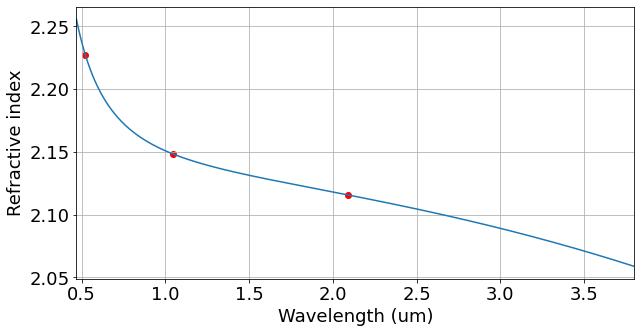

In [7]:
def n_func(wl):
    n = materials.refractive_index('LN_MgO_e', wl/um)
    return n

nLN = n_func(wl_abs)
nw = nLN[f0_ff_index]
n2w = nLN[f0_sh_index]
nhh = nLN[f0_hh_index]

plt.rcParams['figure.figsize'] = [10, 5]
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(fftshift(wl_abs/um), fftshift(nLN))
ax1.scatter(wl_abs[f0_ff_index]/um, nw, c='r')
ax1.scatter(wl_abs[f0_sh_index]/um, n2w, c='r')
ax1.scatter(wl_abs[f0_hh_index]/um, nhh, c='r')
ax1.set_xlim([wl_min/um, wl_max/um])
# ax1.set_ylim([2.1,2.2])
ax1.set_xlabel('Wavelength (um)')
ax1.set_ylabel('Refractive index')
ax1.grid(True)

print('Refractive index at fundamental = %0.3f' %(nw))
print('Refractive index at second harmonic = %0.3f ' %(n2w))
print('Refractive index at half harmonic = %0.3f ' %(nhh))

Now we'll get the propagation constant as usual:
$$ \beta = \frac{\omega n}{c} ,$$

as well as the group velocity and GVD:
$$ 
v_g = \frac{1}{\beta_1} = \left( \frac{\partial \beta}{\partial \omega} \right)^{-1} \\
\mathrm{GVD} = \beta_2 = \frac{\partial^2 \beta}{\partial \omega^2} .
$$

We also need to get the higher order dispersion operator; this can be obtained from the propagation constant as follows:
$$D = \beta(\Omega) - \beta \big|_{\Omega=0} - \frac{\Omega}{v_{ref}}.$$

For this example we'll use $v_{ref} = v_g(2 \omega_0)$.

At this point we can also compute the GVM ($\Delta \beta^\prime $) between the fundamental signal and the moving reference frame:
$$ \Delta \beta^\prime = \frac{1}{v_{ref}} - \frac{1}{v_g(\omega_0)}, $$
and then we can compute how much a pulse at $\omega_0$ will travel in a crystal of length $L$,
$$ \tau =  L \Delta \beta^\prime. $$

GVD at 0.836 um = 336.414 fs^2/mm
GVD at 1.045 um = 238.941 fs^2/mm
Group velocity mismatch between 1.05 um wave and reference frame = 0.840 ps/mm


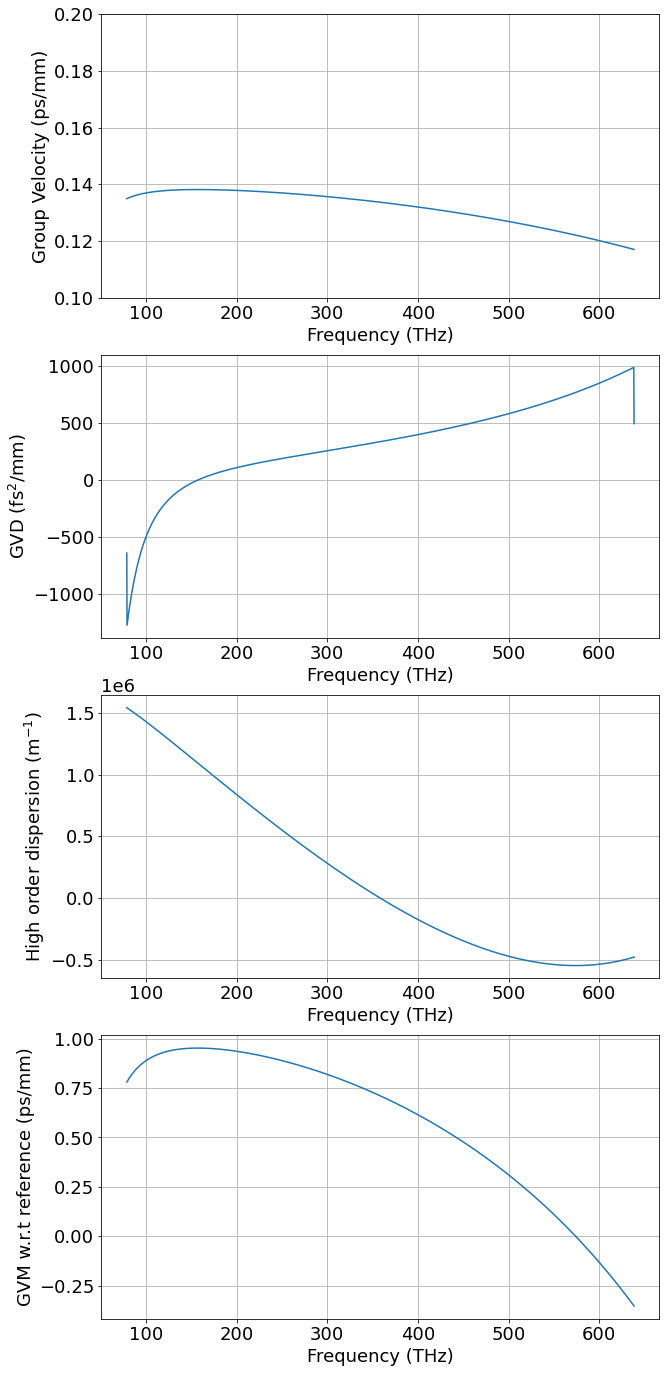

In [8]:
beta = omega_abs*nLN/c
beta_1 = fftshift(np.gradient(fftshift(beta), 2*pi*df))
beta_2 = fftshift(np.gradient(fftshift(beta_1), 2*pi*df))
vg = 1/beta_1

beta_ref = beta[0]
v_ref = vg[f0_sh_index]
D = beta - beta_ref - Omega/v_ref

GVM = 1/v_ref - 1/vg

plt.rcParams['figure.figsize'] = [10, 24]
fig = plt.figure()
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)
ax1.plot(fftshift(f_abs)/THz, fftshift(vg)/(mm/ps));
ax2.plot(fftshift(f_abs)/THz, fftshift(beta_2)/(fs**2/mm));
ax1.set_ylabel('Group Velocity (ps/mm)'); ax2.set_ylabel('GVD (fs$^2$/mm)')
ax1.set_xlabel('Frequency (THz)'); ax2.set_xlabel('Frequency (THz)');
# ax1.set_xlim(150, 500); ax2.set_xlim(150, 500)
ax1.set_ylim(0.1,0.2)
ax1.grid(True); ax2.grid(True)
ax3.plot(fftshift(f_abs)/THz, fftshift(D));
ax3.set_xlabel('Frequency (THz)');
ax3.set_ylabel('High order dispersion (m$^{-1}$)');
ax3.grid(True)
# ax3.set_xlim(150, 500);
ax4.plot(fftshift(f_abs)/THz, fftshift(GVM/(ps/mm)));
ax4.set_ylabel('GVM w.r.t reference (ps/mm)');
ax4.set_xlabel('Frequency (THz)'); ax4.grid(True); 

print('GVD at %0.3f um = %0.3f fs^2/mm' %(wl_ref*1e6, beta_2[0]*1e27))
print('GVD at %0.3f um = %0.3f fs^2/mm' %(wl_ff*1e6, beta_2[f0_ff_index]*1e27))
print('Group velocity mismatch between %0.2f um wave and reference frame = %0.3f ps/mm' %(wl_ff*1e6, GVM[f0_ff_index]/(ps/mm)))

## Quasi Phase Matching

We can get the ideal poling period for SHG is:
$$
\Lambda = \frac{\lambda_{2\omega}}{n_{2\omega} - n_\omega}
$$

In [9]:
poling_period_shg = (wl_sh)/(n2w-nw)
print('Optimal Poling period for SHG starting from pump at %0.2f um is %0.2f um' %(wl_ff*1e6, poling_period_shg*1e6))
poling_period_shg = 2*pi/(beta[f0_sh_index] - 2*beta[f0_ff_index])
print('Optimal Poling period for SHG starting from pump at %0.2f um is %0.2f um' %(wl_ff*1e6, poling_period_shg*1e6))

poling_period = poling_period_shg

delta_b_shg = 2*beta[f0_ff_index] - beta[f0_sh_index]
print('Phase mismatch for SHG before poling = %0.1f 1/m' %(delta_b_shg))
print('Phase mismatch for SHG after poling = %0.2f 1/m' %(delta_b_shg+2*pi/poling_period))

Optimal Poling period for SHG starting from pump at 1.05 um is 6.61 um
Optimal Poling period for SHG starting from pump at 1.05 um is 6.64 um
Phase mismatch for SHG before poling = -946659.5 1/m
Phase mismatch for SHG after poling = 0.00 1/m


In [10]:
poling_period_pdc = (wl_ff)/(nw-nhh)
print('Optimal Poling period for down convertion starting from pump at %0.2f um is %0.2f um' %(wl_ff*1e6, poling_period_pdc*1e6))
# poling_period_pdc = 2*pi/(beta[f0_ff_index] - 2*beta[f0_hh_index])
# print('Optimal Poling period for down convertion starting from pump at %0.2f um is %0.2f um' %(wl_ff*1e6, poling_period_pdc*1e6))

poling_period = poling_period_pdc

delta_b_pdc = 2*beta[f0_hh_index] - beta[f0_ff_index]
print('Phase mismatch before poling = %0.1f 1/m' %(delta_b_pdc))
print('Phase mismatch for PDC after poling = %0.2f 1/m' %(delta_b_pdc+2*pi/poling_period))

Optimal Poling period for down convertion starting from pump at 1.05 um is 32.01 um
Phase mismatch before poling = -192397.9 1/m
Phase mismatch for PDC after poling = 3870.16 1/m


In [11]:
# pp = poling_period_shg
pp = poling_period_pdc
print('Poling period selected is %0.2f um' %(pp/um))
print('Phase mismatch for SHG after poling = %0.2f 1/m' %(delta_b_shg+2*pi/pp))
print('Phase mismatch for PDC after poling = %0.2f 1/m' %(delta_b_pdc+2*pi/pp))

Poling period selected is 32.01 um
Phase mismatch for SHG after poling = -750391.44 1/m
Phase mismatch for PDC after poling = 3870.16 1/m


And now we can modulate the nonlinearity as function of distance using this period. What I want is a function that returns $\chi^{(2)}$ vs distance for any poling pattern. I call this function ```chi2```.

In [12]:
d33 = 10.6e-12
deff = d33

# def chi2(z):
#     poling = (2/pi)*np.cos(z*2*pi/pp)
#     return 2*deff*poling

def chi2(z):
    poling = np.sign(np.cos(z*2*pi/pp))
    return 2*deff*poling

## Nonlinear  Component

Now we create a nonlinear component based on this propagation constant. This nonlinear component implements propagation methods.

In [13]:
crystal = nlo.nonlinear_element(L=5*mm, n_func=n_func, chi2=chi2)

## Input pulse creation

We can find the peak value of the pulse from the intensity
$$
E_p = \sqrt{\frac{2 I}{n_\omega c \epsilon_0}}.
$$

The reference frequency $\omega_{ref}$ is mapped to zero in $\Omega$. So, to generate a pulse at frequency $\omega_0$ we need to modulate it:
$$
p(t) e^{j (\omega_0 - \omega_{ref}) t} = p(t) e^{j \Omega_0 t}.
$$

Let's now generate the pulse, add a bit of noise to it, and plot it to verify it is at the right frequency and looks like we expect it to look.

Here I introduce a class named ```pulse```, the goal is to pack everything relevant to the pulse into one object, just like we did with the nonlinear crystal.

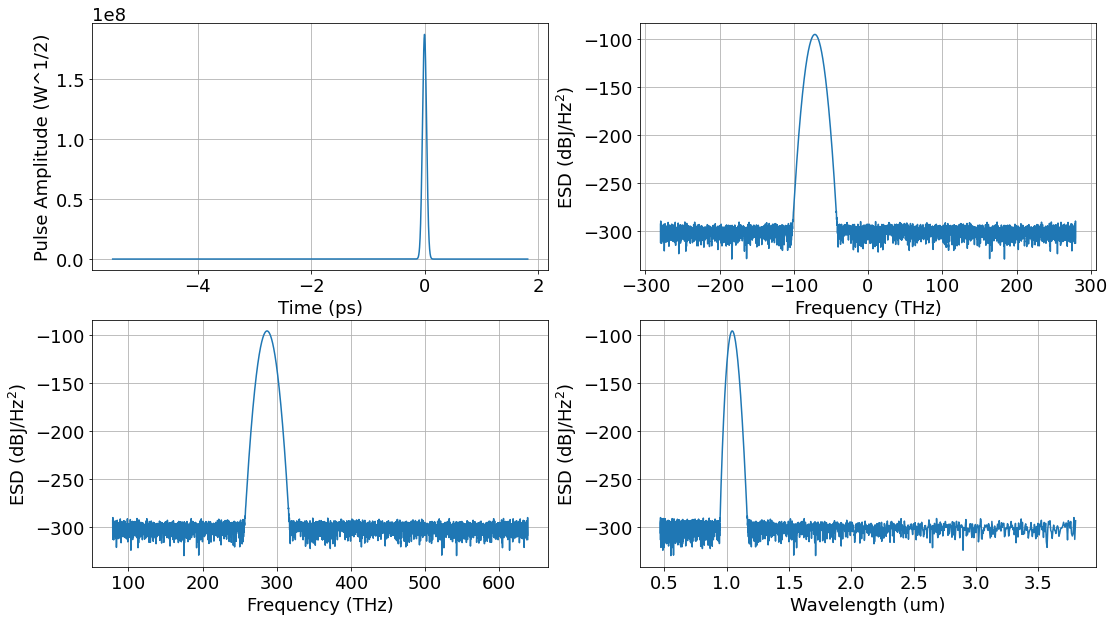

In [14]:
#Frequency offset from reference:
Omega_0 = 2*pi*(f0_ff - f_ref)

#Peak value:
Intensity = 10e13 #10GW/cm^2
n = nw
Epeak = np.sqrt(2*Intensity/(n*c*epsilon_0))

#Pulse width:
tau = 60e-15 

#Noise floor
noise = 0.01*np.random.normal(size=NFFT)

#Pulse creation
x = Epeak*np.exp(-2*np.log(2)*(t/tau)**2)*np.exp(1j*Omega_0*t)
x = x + noise
pulse = nlo.pulse(t, x, wl_ref)

plt.rcParams['figure.figsize'] = [18, 10]
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1 = pulse.plot_mag(ax=ax1, t_unit='ps')
ax2 = pulse.plot_ESD_dB(ax=ax2, label='ESD (dBJ/Hz$^2$)', f_unit = 'THz')
ax3 = pulse.plot_ESD_dB_absfreq(ax=ax3, label='ESD (dBJ/Hz$^2$)', f_unit = 'THz')
ax4 = pulse.plot_ESD_dB_vs_wavelength(ax=ax4, label='ESD (dBJ/Hz$^2$)', wl_unit='um');

## Single pass

In [15]:
Nup = 4 #Upsampling factor
h = 1e-3/100
[a, a_evol] = crystal.propagate_NEE(pulse, h, v_ref=v_ref, Nup=Nup)

Completed propagation along 0.5 mm (0.6 s)
Completed propagation along 1.0 mm (0.5 s)
Completed propagation along 1.5 mm (0.5 s)
Completed propagation along 2.0 mm (0.5 s)
Completed propagation along 2.5 mm (0.5 s)
Completed propagation along 3.0 mm (0.5 s)
Completed propagation along 3.5 mm (0.5 s)
Completed propagation along 4.0 mm (0.5 s)
Completed propagation along 4.5 mm (0.5 s)
Completed propagation along 5.0 mm (0.5 s)


Text(0.5, 0, 'Time (ps)')

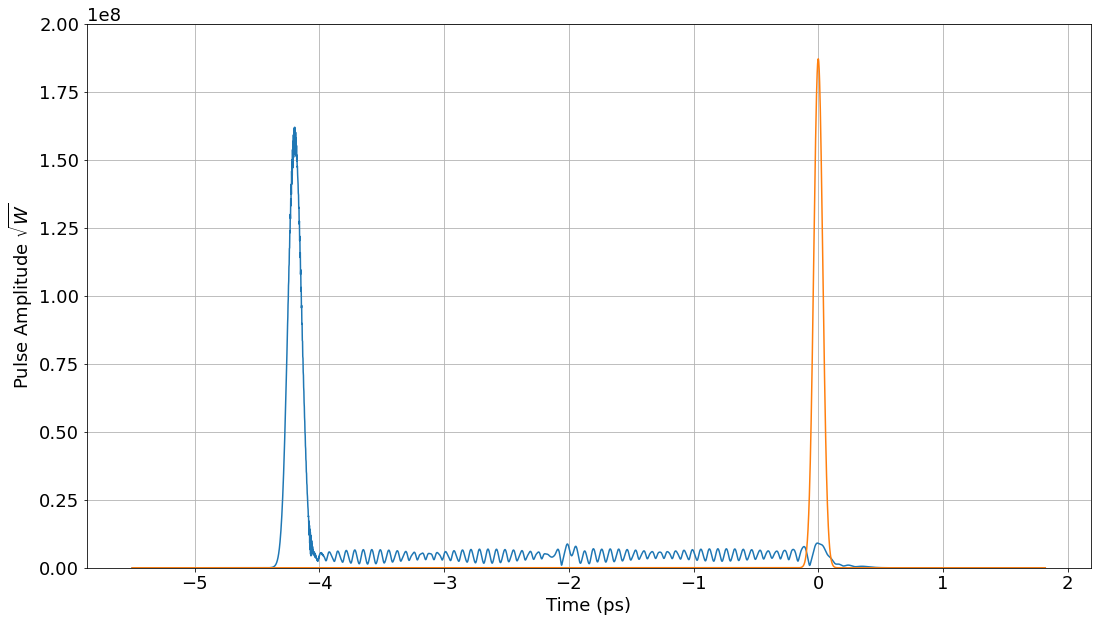

In [16]:
ax1 = nlo.plot_mag(t, a)
ax1 = pulse.plot_mag(ax=ax1)
# ax1.set_xlim(-2.5,0.5)
ax1.set_ylim(0,2e8)
ax1.set_ylabel('Pulse Amplitude $\sqrt{W}$')
ax1.set_xlabel('Time (ps)')

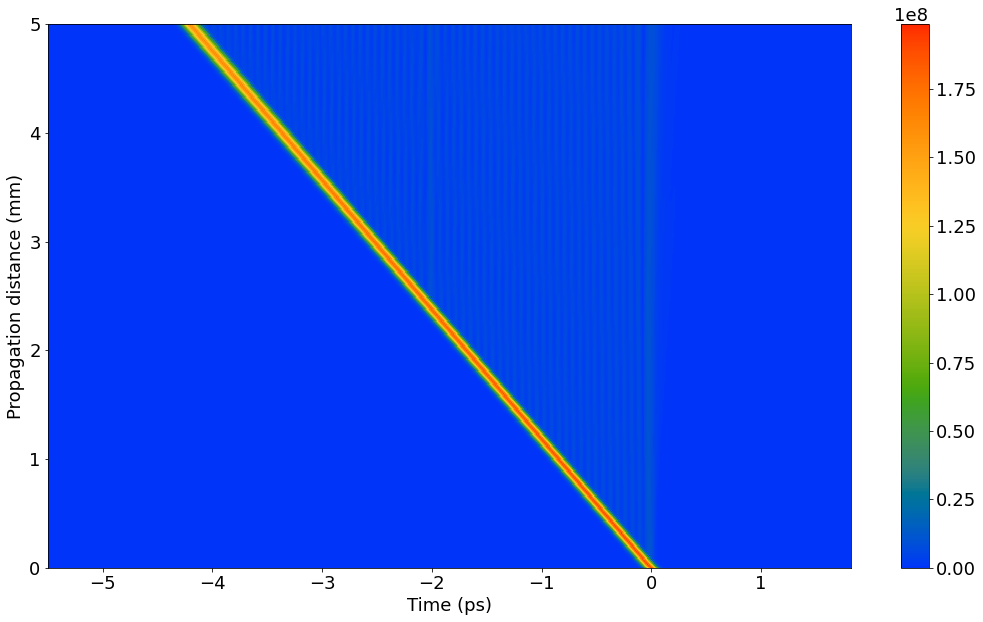

In [17]:
Nsteps = a_evol.shape[1]-1
X,Y = np.meshgrid(t/ps, np.arange(Nsteps+1)*h*1e3)
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.pcolormesh(X, Y, (np.transpose(np.abs(a_evol))), cmap = cc.cm["rainbow"])
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Propagation distance (mm)')
ax.set_ylim([0,5])
plt.colorbar(im, ax=ax)

## Filter and plot harmonics

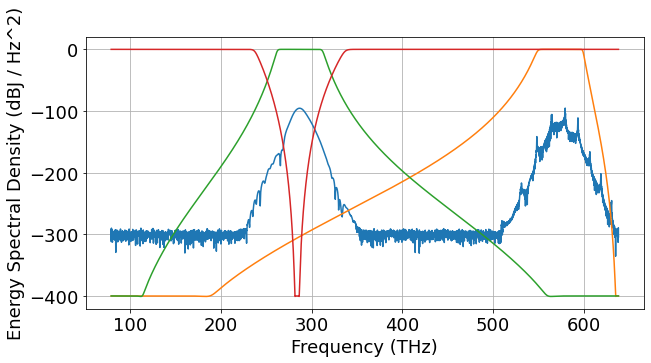

In [18]:
filter_bw = 50e12

f1 = (f0_ff - filter_bw/2 - f_min)/(f_max-f_min)
f2 = (f0_ff + filter_bw/2 - f_min)/(f_max-f_min)
sos = signal.butter(15, [f1, f2], 'bandpass', output='sos')
_, h_ff = signal.sosfreqz(sos, worN=NFFT)

f1 = (f0_sh - filter_bw/2 - f_min)/(f_max-f_min)
f2 = (f0_sh + filter_bw/2 - f_min)/(f_max-f_min)
sos = signal.butter(15, [f1, f2], 'bandpass', output='sos')
_, h_sh = signal.sosfreqz(sos, worN=NFFT)

f1 = (f0_ff - 1*filter_bw - f_min)/(f_max-f_min)
f2 = (f0_ff + 1*filter_bw - f_min)/(f_max-f_min)
sos = signal.butter(15, [f1, f2], 'bandstop', output='sos')
_, h_fb = signal.sosfreqz(sos, worN=NFFT)

a_sh = ifft(fft(a)*fftshift(h_sh))
a_ff = ifft(fft(a)*fftshift(h_ff))

plt.rcParams['figure.figsize'] = [10, 5]
ax1 = nlo.plot_ESD_dB_absfreq(t, a, f_ref)
ax1.plot(fftshift(f+f_ref)*1e-12, 20*np.log10(abs(h_sh + 1e-20)));
ax1.plot(fftshift(f+f_ref)*1e-12, 20*np.log10(abs(h_ff + 1e-20)));
ax1.plot(fftshift(f+f_ref)*1e-12, 20*np.log10(abs(h_fb + 1e-20)));
# ax1.set_ylim([-100,10])
# ax1.set_xlim([150, 500])

(0.0, 200000000.0)

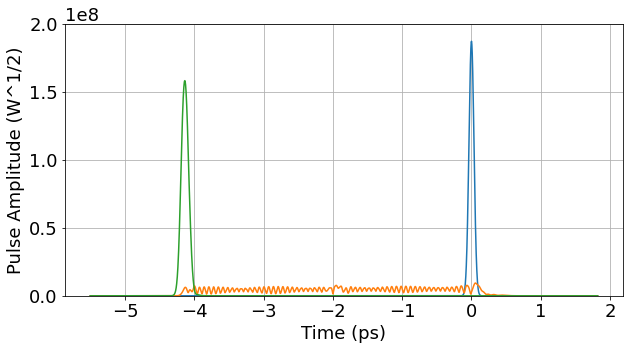

In [19]:
plt.rcParams['figure.figsize'] = [10, 5]
ax1 = pulse.plot_mag()
ax1 = nlo.plot_mag(t, a_sh, ax=ax1)
ax1 = nlo.plot_mag(t, a_ff, ax=ax1)
# ax1.set_xlim(-2.5,0.5)
ax1.set_ylim(0, 2e8)

## Spectrum

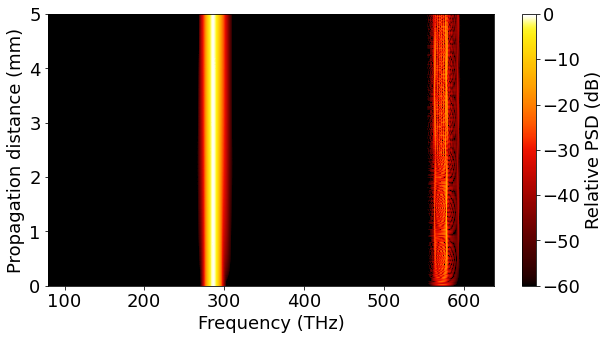

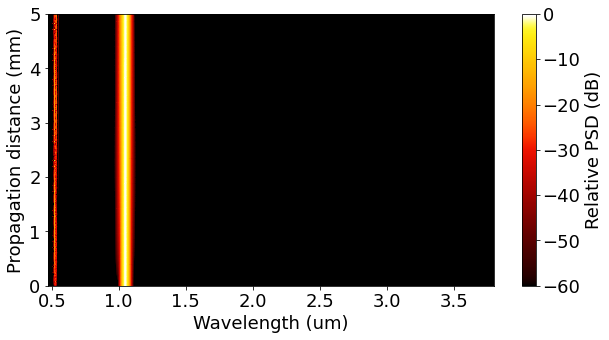

In [20]:
A_evol = np.zeros((t.size, Nsteps+1))

for k in range(Nsteps+1):
    x = a_evol[:,k]
    _ , Aesd = nlo.get_esd(t, x)
    A_evol[:,k] = 10*np.log10(Aesd)

A_evol = A_evol - np.amax(A_evol)
A_evol = fftshift(A_evol, axes=0)

X,Y = np.meshgrid(fftshift(f+f_ref)/THz, np.arange(Nsteps+1)*h*1e3)
plt.figure()
plt.pcolormesh(X, Y, (np.transpose(A_evol)), cmap = cc.cm["fire"], vmin=-60, vmax=0)
cb = plt.colorbar()
cb.set_label('Relative PSD (dB)')
plt.xlabel('Frequency (THz)')
plt.ylabel('Propagation distance (mm)');

wl_array = c/(fftshift(f)+f_ref)/um
Xwl,Ywl = np.meshgrid(wl_array, np.arange(Nsteps+1)*h*1e3)
plt.figure()
plt.pcolormesh(Xwl, Ywl, (np.transpose(A_evol)), cmap = cc.cm["fire"], vmin=-60, vmax=0)
cb = plt.colorbar()
cb.set_label('Relative PSD (dB)')
plt.xlabel('Wavelength (um)')
plt.ylabel('Propagation distance (mm)');

## Towards OPO

## Feedback Loop

Now we create the linear element that represents the feedback loop. Let's make if a function of the detuning $\delta T$ so we can change that easily later on.

In [21]:
def feedback_loop(dT):
    #Output coupler loss
    Co_loss = 1-0.65  
    
    #Cavity dispersion parameters
    phi2 = 25
    phi3 = 76
    phi4 = -13020
    phi5 = 983328

    #Feedback loop
    deltaphi = (phi2/2)*Omega**2 + (phi3/6)*Omega**3 + (phi4/24)*Omega**4 + (phi5/120)*Omega**5
    l = c*dT/wl_ff #Detuning parameter l
    phi = pi*l + dT*Omega + deltaphi

    #Linear element representing this feedback path in the freq domain
    fb = np.sqrt(Co_loss)*np.exp(1j*phi)
    
    return fb

In [22]:
Nup = 4 #Upsampling factor
h = 1e-3/100

def OPO(pump, crystal, feedback, Nrt=200):
    
    #Unpack the pump
    x = pump.a 
    t = pump.t
    
    #Initial feedback pulse is just noise
    noise = 0.01*np.random.normal(size=t.size)
    x_fb = noise
    
    for kn in range(Nrt):
        
        #Pulse at the input
        p_in = nlo.pulse(t, x+x_fb, wl_ref)
        
        [x_out, _] = crystal.propagate_NEE(p_in, h, v_ref=v_ref, Nup=2, verbose=False)
        
        #Apply feedback
        x_fb = 0.6*ifft(feedback*fft(x_out)*fftshift(h_fb))
        
        if (kn+1)%5==0:
            print('Completed roundtrip %i' %(kn+1))
        
    return nlo.pulse(t, x_out, wl_ref)

In [23]:
feedback = feedback_loop(0)
x = OPO(pulse, crystal, feedback, Nrt=15)

Completed roundtrip 5
Completed roundtrip 10
Completed roundtrip 15


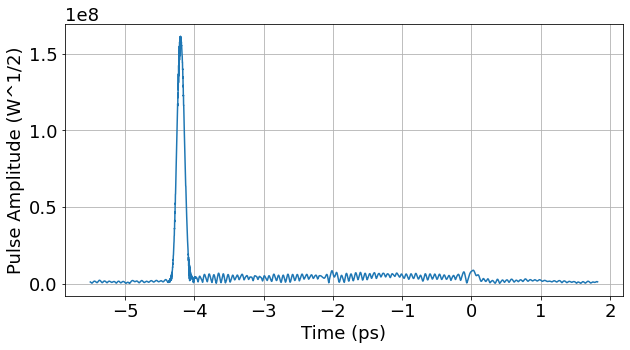

In [24]:
x.plot_mag()

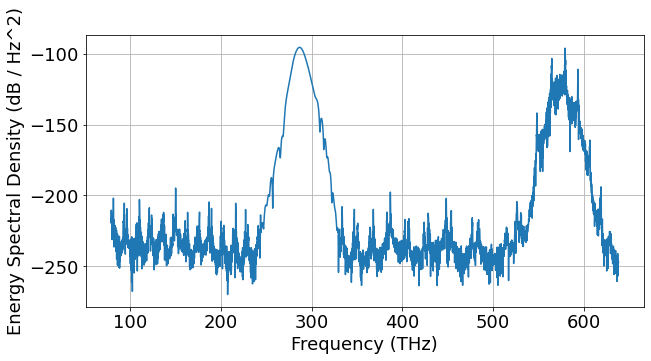

In [25]:
x.plot_ESD_dB_absfreq()

In [26]:
%load_ext version_information
%version_information scipy, numpy, matplotlib

Software versions
Python 3.7.6 64bit [MSC v.1916 64 bit (AMD64)]
IPython 7.13.0
OS Windows 10 10.0.16299 SP0
scipy 1.4.1
numpy 1.18.1
matplotlib 3.2.1
Mon Apr 13 16:40:03 2020 Pacific Daylight Time